 # 读取数据 

In [1]:
# load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

# Load Trian and Test Data
house_price = pd.read_csv("train.csv") 
house_id= house_price.Id
house_test = pd.read_csv("test.csv")
house_test_id = house_test.Id
# Drop house ID inplace
house_price.drop("Id",1,inplace=True)
house_test.drop("Id",1,inplace=True)
# check the dimension of the dataframe
print(house_price.shape)
print(house_test.shape)
# A glance at the dataframe


(1460, 80)
(1459, 79)


In [2]:
# Look at the skewness of the data
house_price.skew()
# Miscval is variable with the highest skewness
# we can apply the log1p to reduce the skewness


MSSubClass        1.407657
LotFrontage       2.163569
LotArea          12.207688
OverallQual       0.216944
OverallCond       0.693067
YearBuilt        -0.613461
YearRemodAdd     -0.503562
MasVnrArea        2.669084
BsmtFinSF1        1.685503
BsmtFinSF2        4.255261
BsmtUnfSF         0.920268
TotalBsmtSF       1.524255
1stFlrSF          1.376757
2ndFlrSF          0.813030
LowQualFinSF      9.011341
GrLivArea         1.366560
BsmtFullBath      0.596067
BsmtHalfBath      4.103403
FullBath          0.036562
HalfBath          0.675897
BedroomAbvGr      0.211790
KitchenAbvGr      4.488397
TotRmsAbvGrd      0.676341
Fireplaces        0.649565
GarageYrBlt      -0.649415
GarageCars       -0.342549
GarageArea        0.179981
WoodDeckSF        1.541376
OpenPorchSF       2.364342
EnclosedPorch     3.089872
3SsnPorch        10.304342
ScreenPorch       4.122214
PoolArea         14.828374
MiscVal          24.476794
MoSold            0.212053
YrSold            0.096269
SalePrice         1.882876
d

In [3]:
# Check the number of columns of specific data type
print(house_price.dtypes.value_counts())


object     43
int64      34
float64     3
dtype: int64


In [4]:
# Make a new dataframe containing only numeric data columns
numeric_feature = [a for a in range(len(house_price.dtypes)) if house_price.dtypes[a] in ['int64','float64']]
numeric_fet_test = [a for a in range(len(house_test.dtypes)) if house_test.dtypes[a] in ['int64','float64']]
numeric_data = house_price.iloc[:,numeric_feature]
numeric_test = house_test.iloc[:,numeric_fet_test]


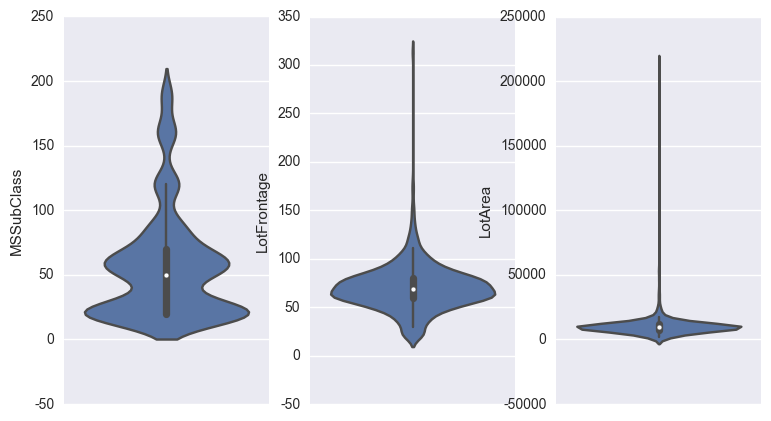

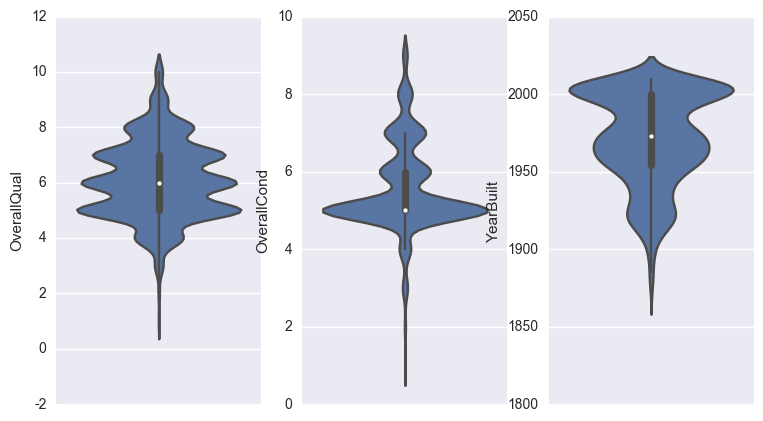

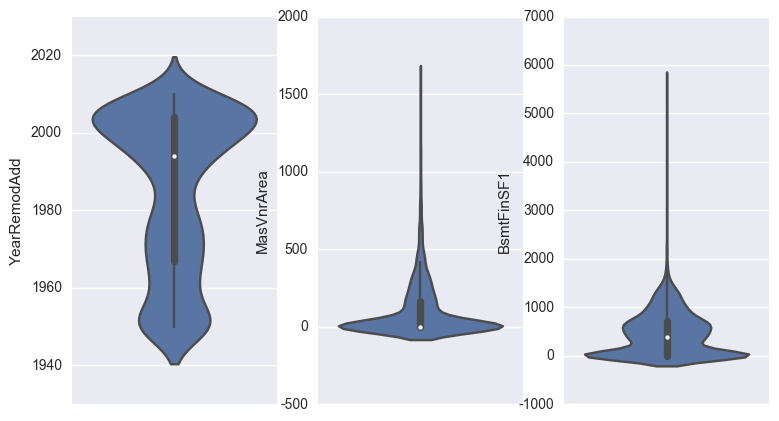

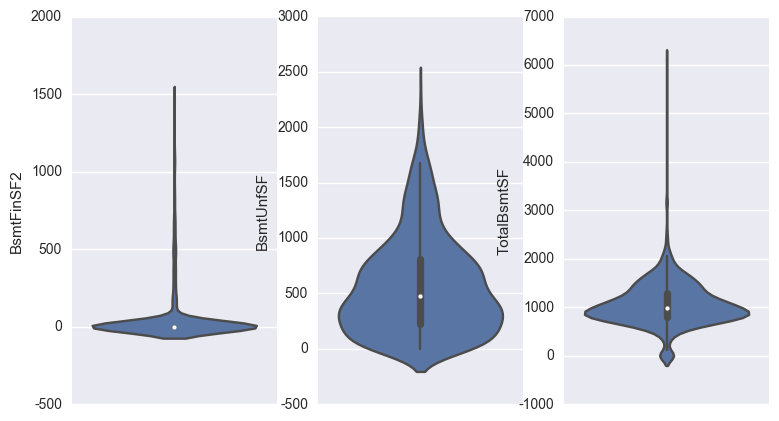

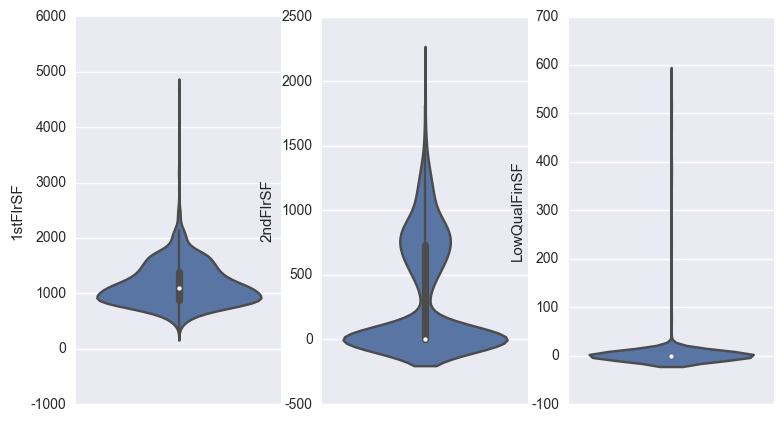

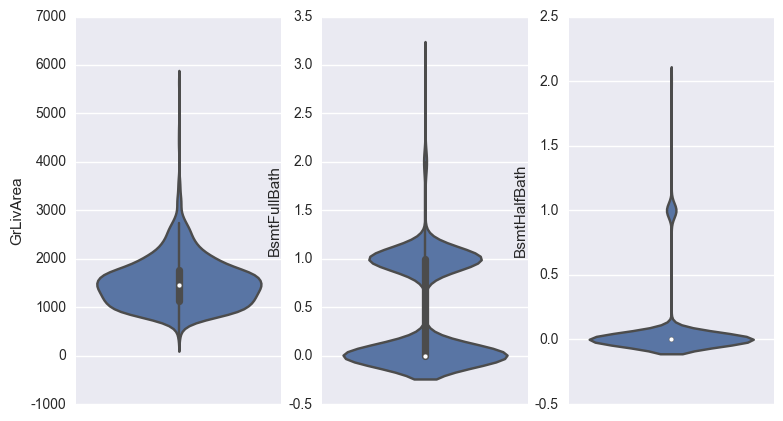

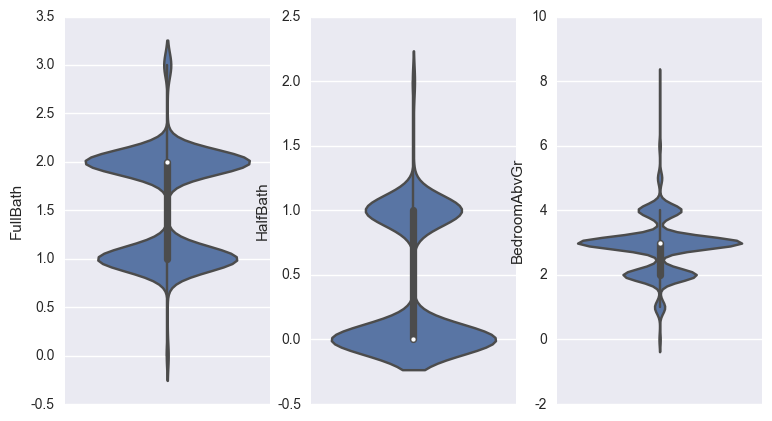

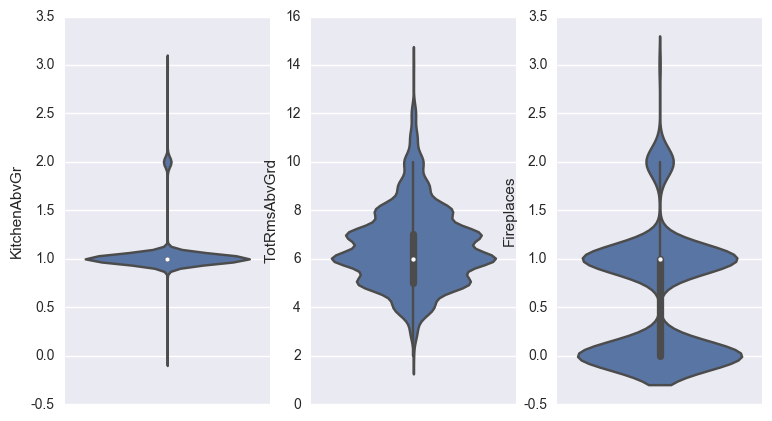

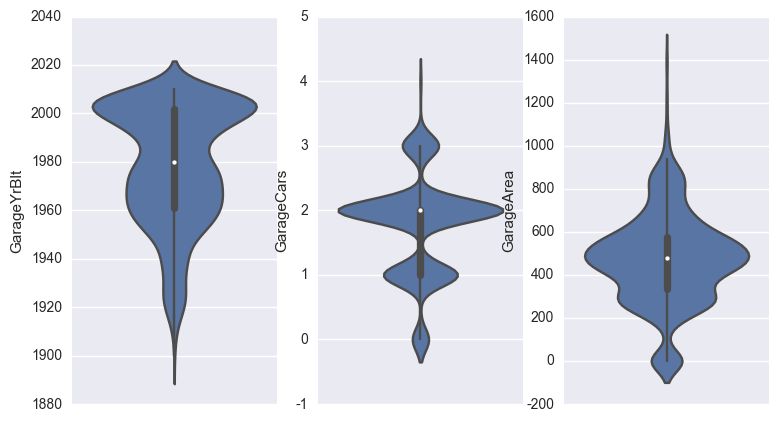

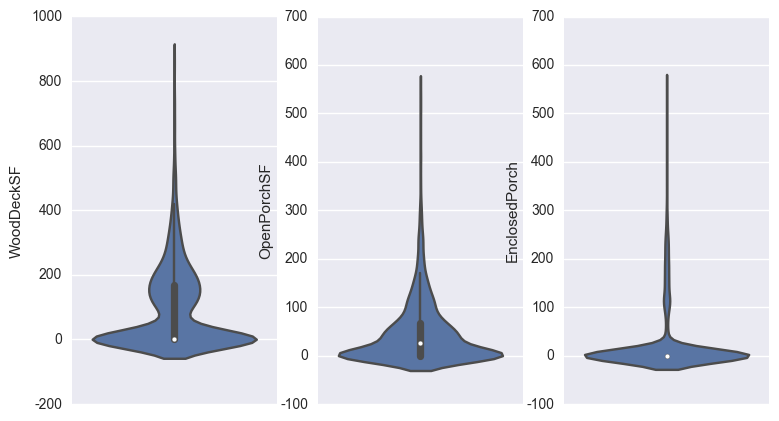

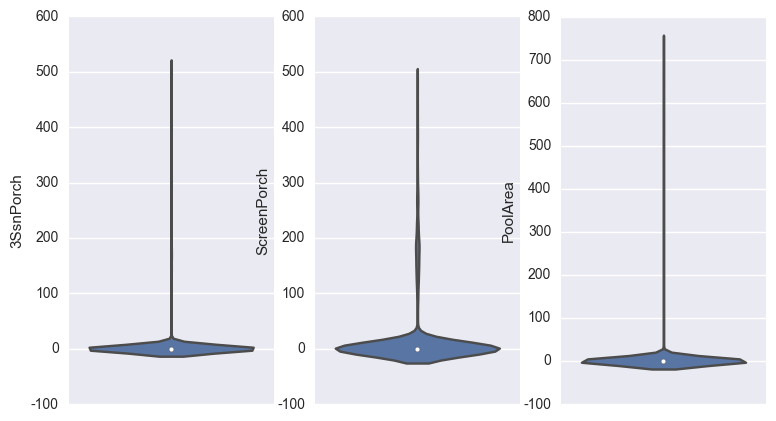

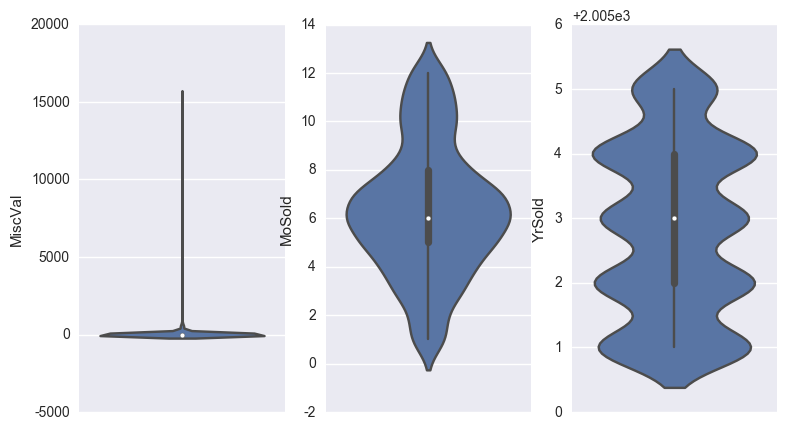

In [5]:
ncol = 3
nrow = 12
for i in range(nrow):
    fg,ax=plt.subplots(nrows=1,ncols=ncol,figsize=(9,5))
    for j in range(ncol):
        sns.violinplot(y = numeric_data.iloc[:,(i*ncol+j)],ax=ax[j])


In [6]:
# finding the best correlated features among all features,
# we are keeping the threshold 0.5 to limit the number of features
correlation = numeric_data.corr().abs()
correlation = pd.DataFrame(np.triu(correlation))
high_correlated = correlation.stack().sort_values(kind='quicksort')
high_correlated = high_correlated[(high_correlated >= 0.5)&(high_correlated<1)]
high_cor_column =  high_correlated.index.values


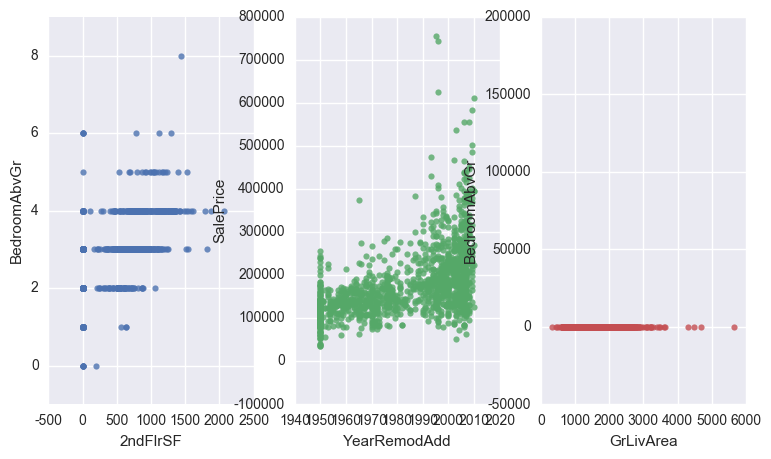

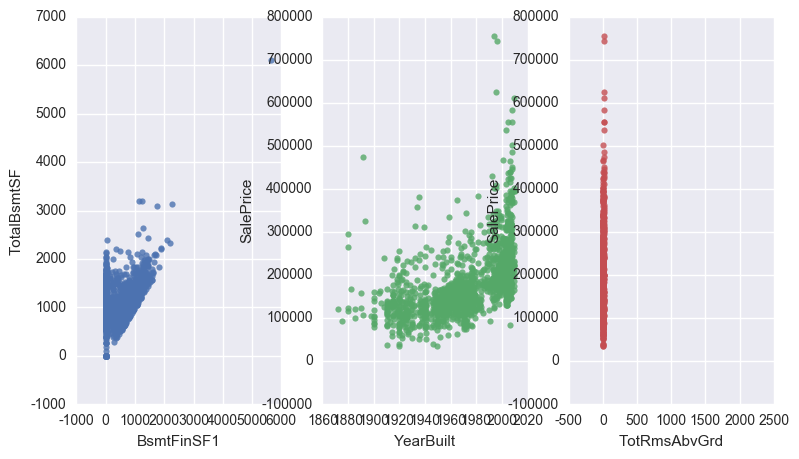

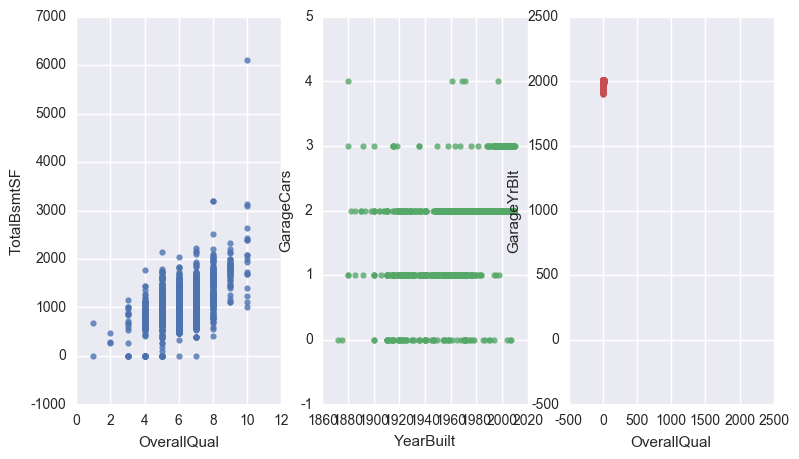

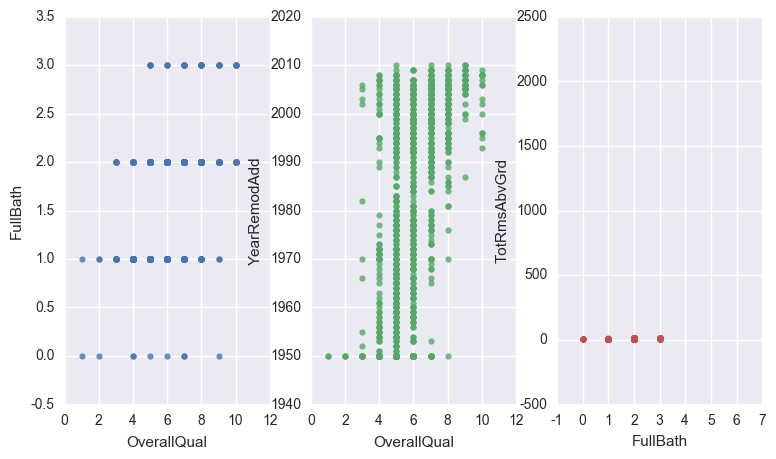

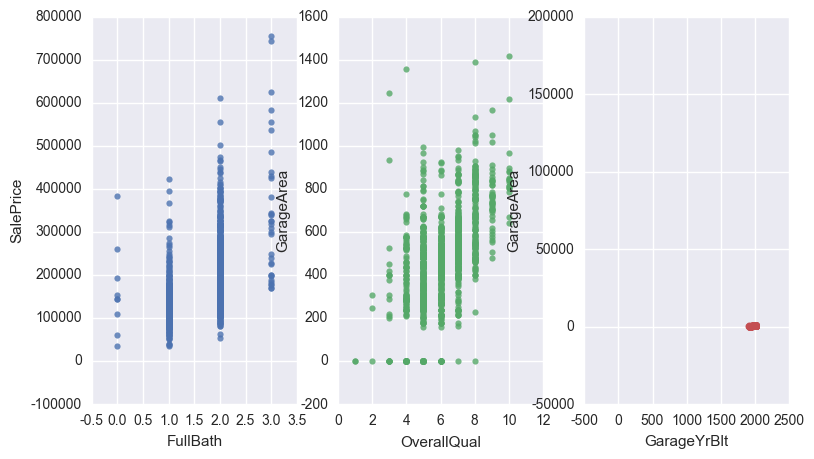

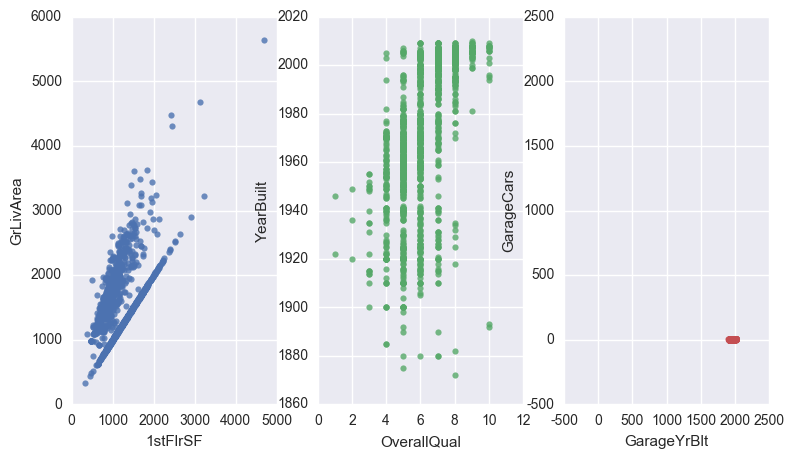

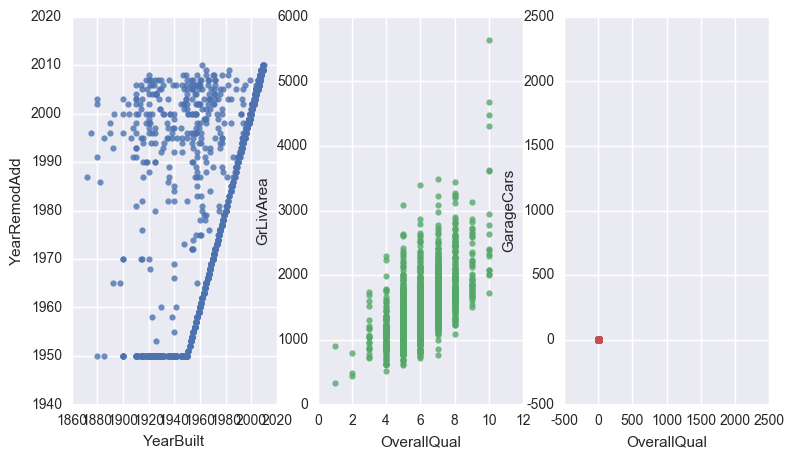

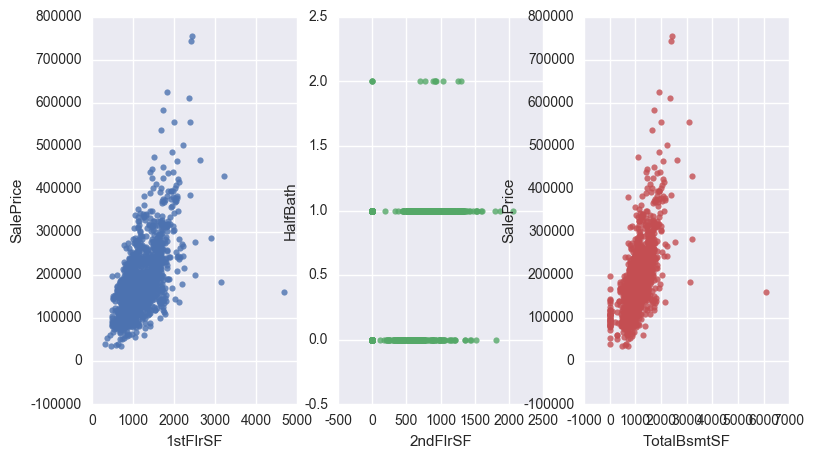

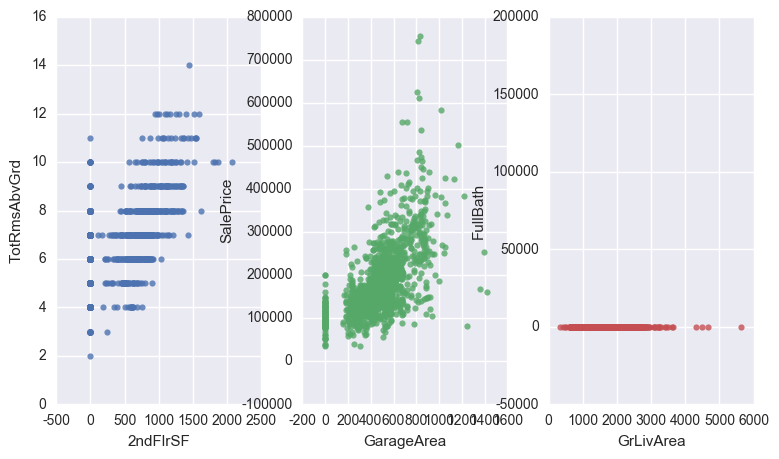

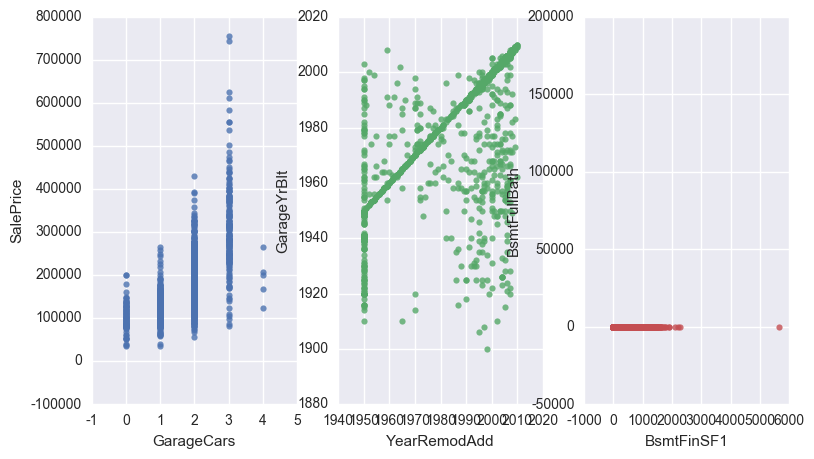

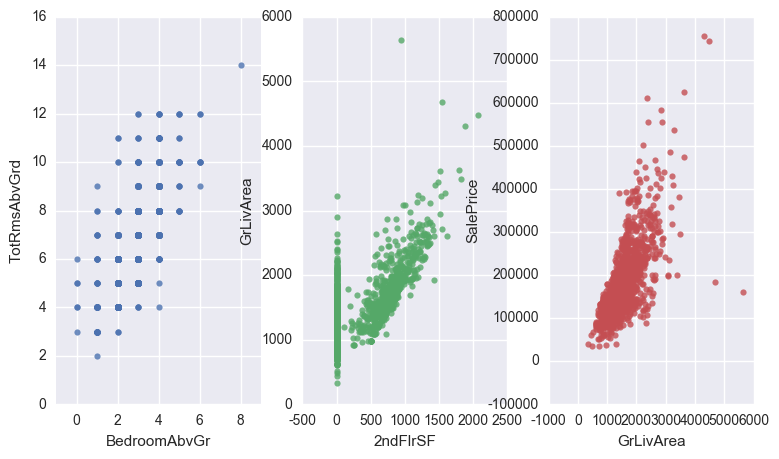

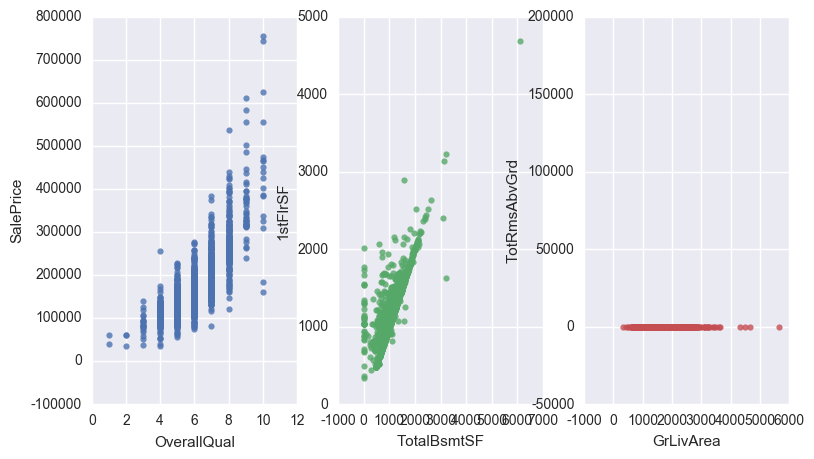

In [7]:
# Visualize scatter plot for top correlated features
x_col=[]
y_col =[]
for i in range(len(high_cor_column)):
    x_col.append(numeric_data.columns[high_cor_column[i][0]])
    y_col.append(numeric_data.columns[high_cor_column[i][1]])
for i in range(nrow):
    fg,ax=plt.subplots(nrows=1,ncols=ncol,figsize=(9,5))
    for j in range(ncol):
        sns.regplot(x=x_col[i*ncol+j],y=y_col[i*ncol+j],data=numeric_data,ax = ax[j],fit_reg=False)


In [8]:
# Make different data frame for the category data in train and test
cat_name = house_price.columns.difference(house_price.columns[numeric_feature])
cat_data = house_price.ix[:,cat_name]
cat_name_test = house_test.columns.difference(house_test.columns[numeric_fet_test])
cat_test = house_price.ix[:,cat_name_test]


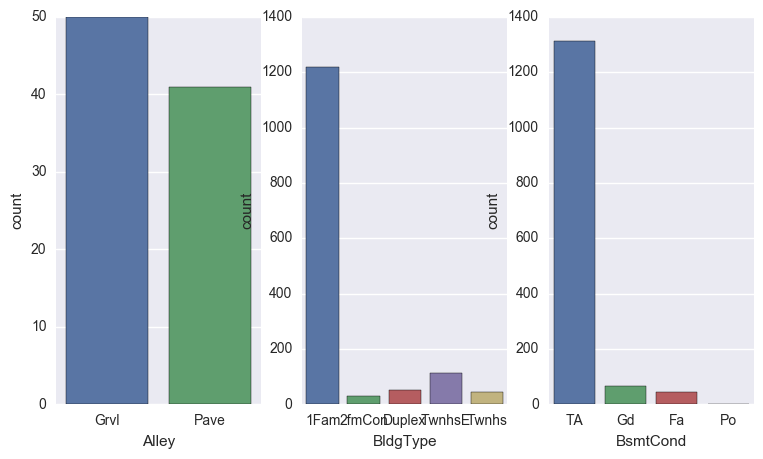

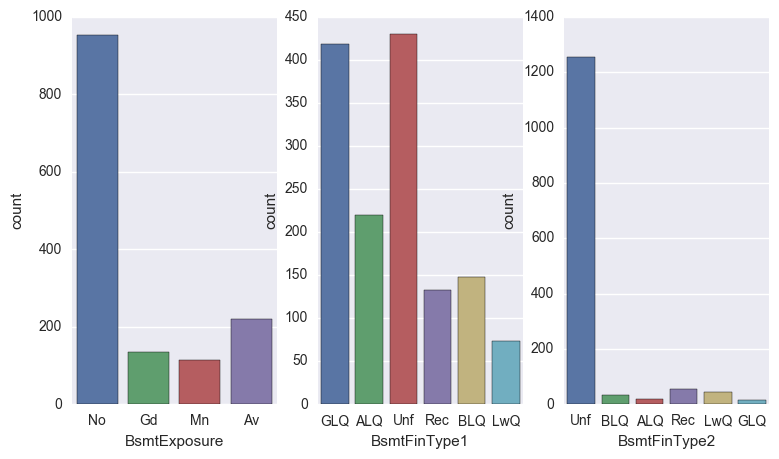

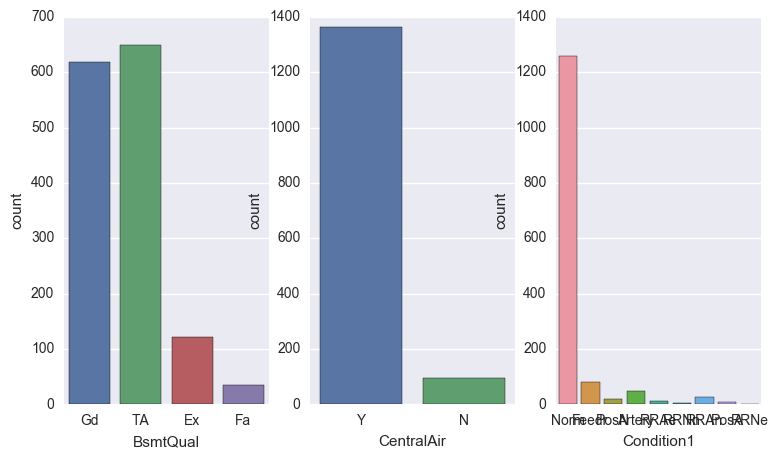

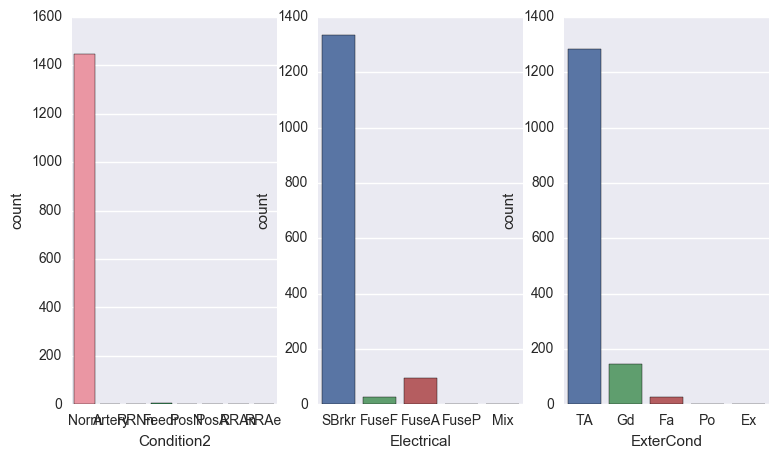

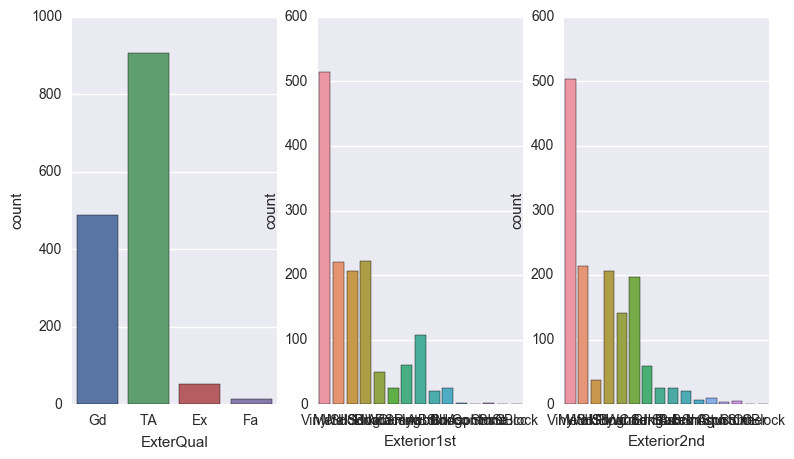

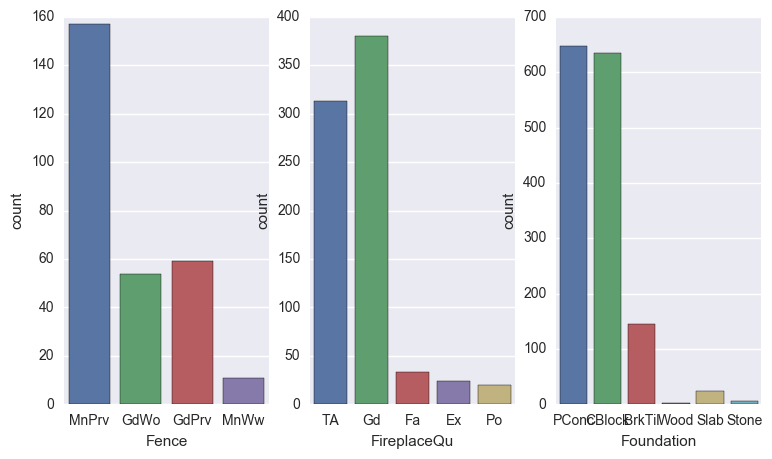

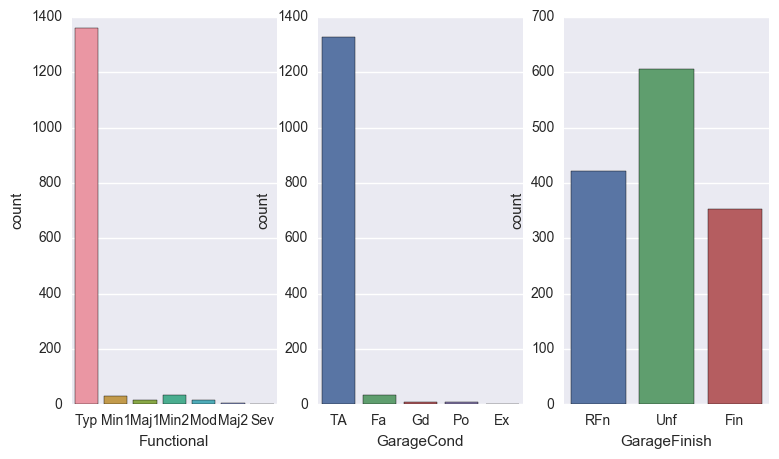

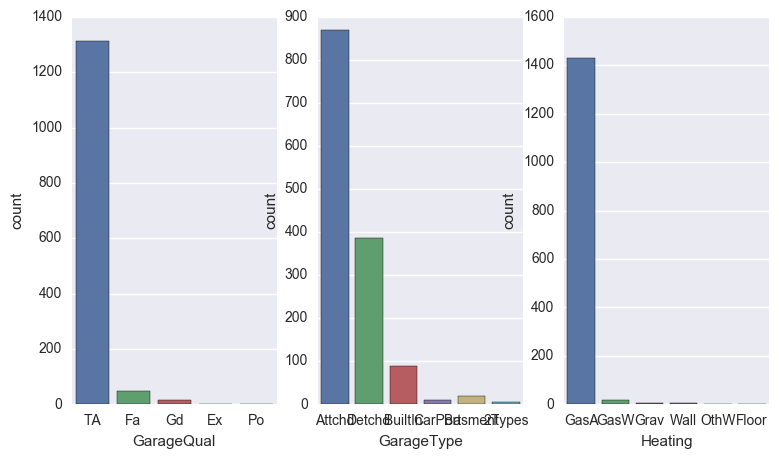

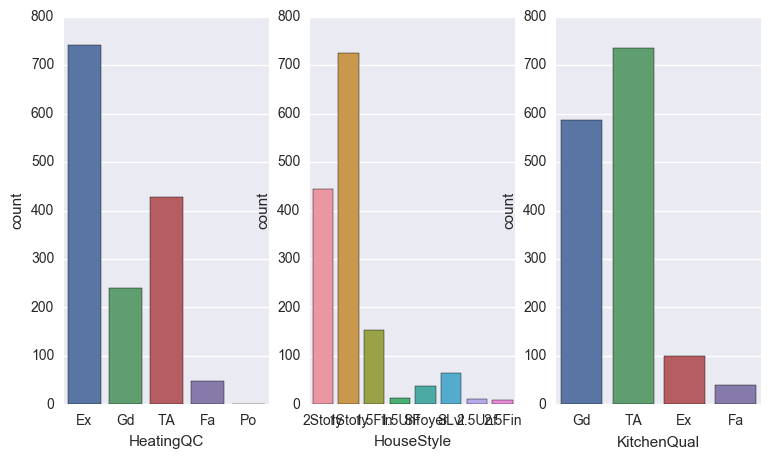

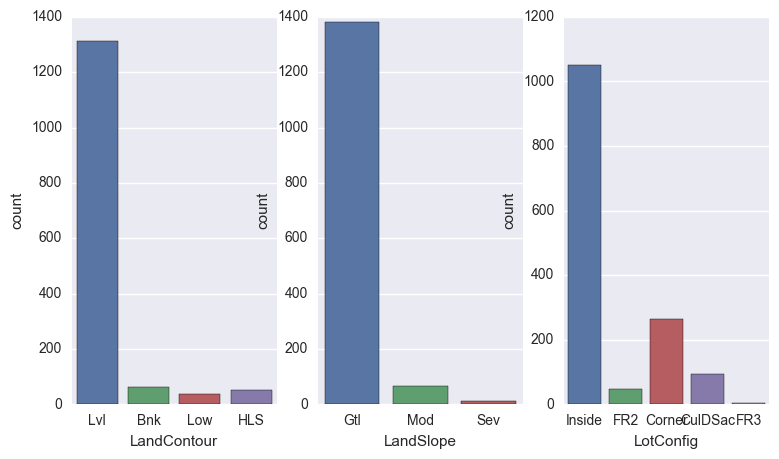

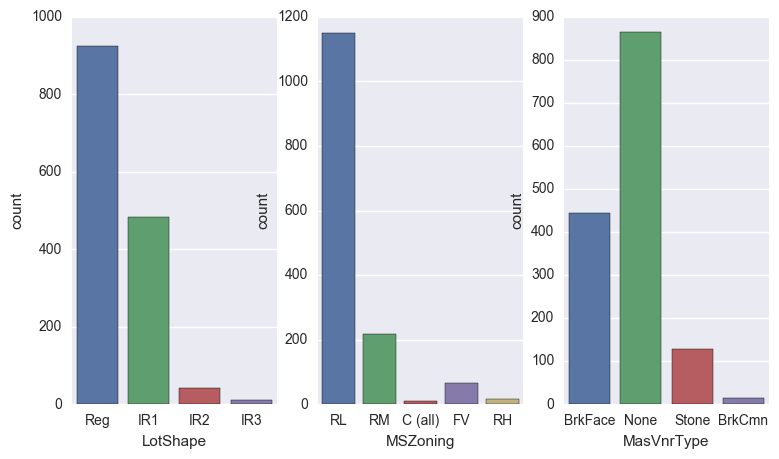

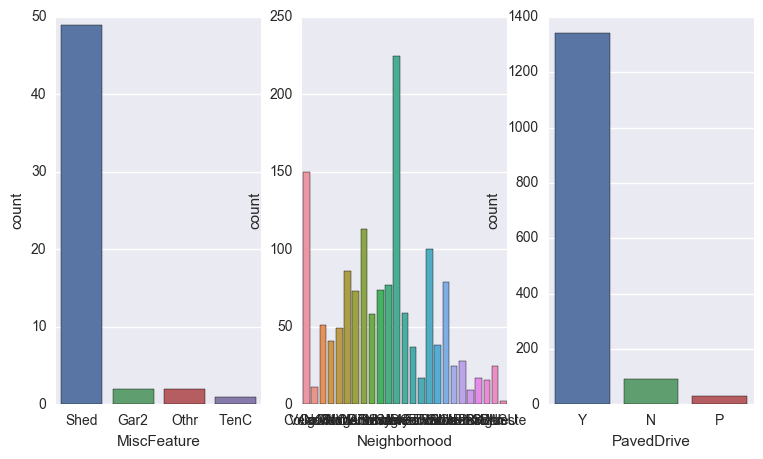

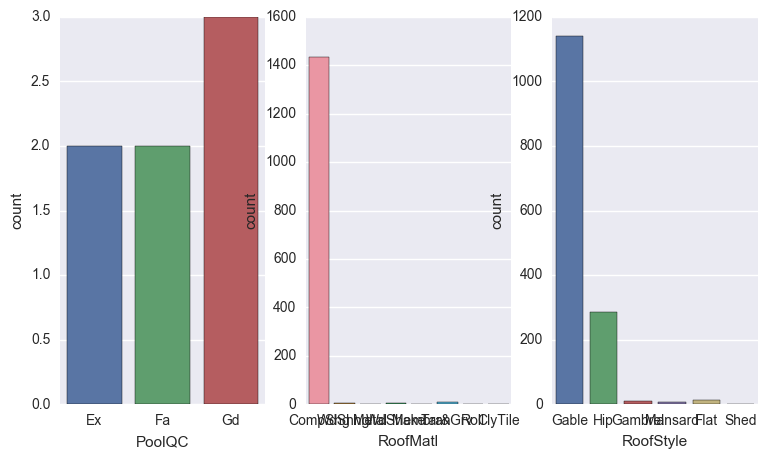

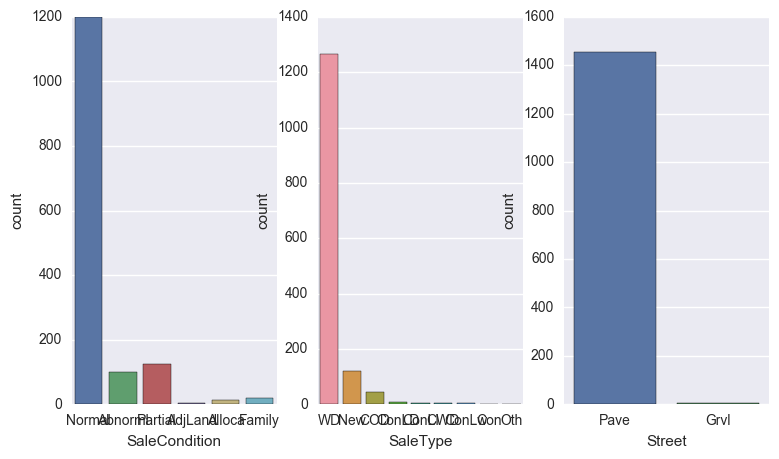

In [9]:
# Visualize Distribution of categorical data
n_col =3
n_row = 14
for i in range(n_row):
    fg,ax = plt.subplots(nrows=1,ncols=n_col,figsize=(9,5))
    for j in range(n_col):
        sns.countplot(x =cat_data.iloc[:, (i*n_col + j)],ax=ax[j])


In [10]:
# Replace numpy nan value is string NA values
# Remember, there are different ways to deal with missing values but here we are not going to deal with it
new_dataset = house_price.copy()
new_dataset = new_dataset.replace(to_replace=np.nan,value="NA")
new_test = house_test.copy()
new_test = new_test.replace(to_replace=np.nan,value="NA")


In [11]:
# Encoding of categorical data of train data
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
labels = []
for i in cat_name:
    train_label = new_dataset[i].unique()
    test_label = new_test[i].unique()
    labels.append(list(set(train_label)|set(test_label)))
encoded_cat = []
for i in range(len(cat_name)):
    label_coder = LabelEncoder()
    label_coder.fit(labels[i])
    cat_col = label_coder.transform(new_dataset.loc[:,cat_name[i]])
    cat_col = cat_col.reshape(new_dataset.shape[0],1)
    onehot_encoder = OneHotEncoder(sparse=False,n_values=len(labels[i]))
    cat_col = onehot_encoder.fit_transform(cat_col)
    encoded_cat.append(cat_col)
encoded_frame = np.column_stack(encoded_cat)
# Concatenate encoded category and numeric data
new_data = np.concatenate((encoded_frame,numeric_data),axis=1)
new_data = pd.DataFrame(new_data)
print(new_data.shape)


(1460, 312)


 # Validation set from Train Data

In [12]:
# Create Validation set from training set
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
x_train,x_val,y_train,y_val = train_test_split(new_data.iloc[:,0:310],new_data[311],random_state = 0)
# Fill the missing values of numeric data with the mean of the columns
x_train = x_train.fillna(x_train.mean())
x_val = x_val.fillna(x_val.mean())
# Make sure that shape of the dataframe is not wrong
print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(1095, 310)
(365, 310)
(1095,)
(365,)


 # Linear Regression

In [13]:
# Implement most basic regression technique
from sklearn.linear_model import LinearRegression
linear_regression = LinearRegression()
linear_regression = linear_regression.fit(x_train,y_train)
predicted = linear_regression.predict(x_val)
linear_acc = mean_absolute_error(y_val,predicted)
print(linear_acc)

10173286857.4


# Ridge Regression

In [14]:
# Implement Regression with penalty (Ridge Regression)
# This regression does not eliminate features, because coefficient can not be zero
from sklearn.linear_model import Ridge
ridge_regression = Ridge()
ridge_regression = ridge_regression.fit(x_train,y_train)
predicted = ridge_regression.predict(x_val)
ridge_acc = mean_absolute_error(y_val,predicted)
print(ridge_acc)

20677.973457


# Lasso Regression

In [15]:
# Implement Regression with penalty (Lasso Regression)
# This regression does  eliminate features, because coefficient can  be zero
from sklearn.linear_model import Lasso
lasso_regression = Lasso()
lasso_regression = lasso_regression.fit(x_train,y_train)
predicted = lasso_regression.predict(x_val)
lasso_acc = mean_absolute_error(y_val,predicted)
print(lasso_acc)

21104.5628894


 # Elastic Regression

In [16]:
# Combination of both the regression Ridge and Lasso, It includes L2 and L1 penalties
from sklearn.linear_model import ElasticNet
elastic_regression = ElasticNet()
elastic_regression = elastic_regression.fit(x_train,y_train)
predicted = elastic_regression.predict(x_val)
elastic_acc = mean_absolute_error(y_val,predicted)
print(elastic_acc)

20227.1392221


 # KNN

In [17]:
# K nearest Neighbour for k =5
from sklearn.neighbors import KNeighborsRegressor
knn_regression = KNeighborsRegressor()
knn_regression = knn_regression.fit(x_train,y_train)
predicted = knn_regression.predict(x_val)
knn_acc = mean_absolute_error(y_val,predicted)
print(knn_acc)

27695.1194521


# Decision Tree Regressor

In [18]:
# Decision Tree Regressor
from sklearn.tree import DecisionTreeRegressor
decision_regression = DecisionTreeRegressor()
decision_regression = decision_regression.fit(x_train,y_train)
predicted = decision_regression.predict(x_val)
decision_acc = mean_absolute_error(y_val,predicted)
print(decision_acc)

26791.7232877


# Support Vector Machine

In [19]:
from sklearn.svm import SVR
svm_regression = SVR()
svm_regression = svm_regression.fit(x_train,y_train)
predicted = svm_regression.predict(x_val)
svm_acc = mean_absolute_error(y_val,predicted)
print(svm_acc)

55234.6514865


# Bagging

In [20]:
from sklearn.ensemble import BaggingRegressor
bagging_regression = BaggingRegressor()
bagging_regression = bagging_regression.fit(x_train,y_train)
predicted = bagging_regression.predict(x_val)
bagging_acc = mean_absolute_error(y_val,predicted)
print(bagging_acc)

18400.1835616


# Boosting

In [24]:
# Boosting with default settings
from sklearn.ensemble import AdaBoostRegressor
boosting_regression = AdaBoostRegressor()
boosting_regression = boosting_regression.fit(x_train,y_train)
predicted = boosting_regression.predict(x_val)
boosting_acc = mean_absolute_error(y_val,predicted)

print(boosting_acc)

23460.0668863


# Test best algorithm Bagging

In [22]:
# One hot Encoding of the test data
encoded_test = []
for i in range(len(cat_name)):
    label_coder = LabelEncoder()
    label_coder.fit(labels[i])
    test_col = label_coder.transform(new_test.loc[:,cat_name[i]])
    test_col = test_col.reshape(new_test.shape[0],1)
    onehot_encoder = OneHotEncoder(sparse=False,n_values=len(labels[i]))
    test_col = onehot_encoder.fit_transform(test_col)
    encoded_test.append(test_col)
    
encoded_frame = np.column_stack(encoded_test)
new_test = np.concatenate((encoded_frame,numeric_test),axis=1)
new_test = pd.DataFrame(new_test)
new_test = new_test.fillna(new_test.mean())

# Now combine val and train to make final Bagging model
train = pd.concat([x_train,x_val])
train_label = pd.concat([y_train,y_val])
bagging_regression = BaggingRegressor()
bagging_regression = bagging_regression.fit(train,train_label)
# Prediction based on the bagging algorith 
baggin_test = bagging_regression.predict(new_test)
final = pd.DataFrame(house_test_id)
final["SalePrice"] = baggin_test
final.head()
# final.to_csv("final.csv",index=False)

,Id,SalePrice
0,1461,131220.0
1,1462,156840.0
2,1463,177350.0
3,1464,175685.0
4,1465,185650.0
